# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process, calc

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_human.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']
num_recount2_experiments = params['num_recount2_experiments']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_data_file = params['normalized_compendium_data_file']
shared_genes_file = params['shared_genes_file']
scaler_file = params['scaler_transform_file']

### Download subset of recount2 to use as a compendium
The compendium will be composed of random experiments + the selected template experiment

In [4]:
%%R
# Select 59
# Select a
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("derfinder")
#BiocManager::install("recount")

NULL


In [5]:
%%R
library('recount')

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x

In [6]:
%%R -i project_id -i num_recount2_experiments -i local_dir -i base_dir

source('../generic_expression_patterns_modules/download_recount2_data.R')

get_recount2_compendium(project_id, num_recount2_experiments, local_dir, base_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:58:05 downloading the metadata to /tmp/Rtmp7SnETA/metadata_clean_sra.Rdata

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://github.com/leekgroup/recount-website/blob/master/metadata/metadata_clean_sra.Rdata?raw=true'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/octet-stream'
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2531337 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:58:23 downloading file rse_gene.Rdata to SRP044956

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP044956/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2454112 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 2.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:58:24 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 2.8 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:58:36 downloading file rse_gene.Rdata to SRP034953

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP034953/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2185007 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:58:37 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:58:49 downloading file rse_gene.Rdata to SRP002278

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP002278/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1682209 bytes (1.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:58:50 downloading file rse_gene.Rdata to SRP034547

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:04 downloading file rse_gene.Rdata to SRP061255

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP061255/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1695970 bytes (1.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:05 downloading file rse_gene.Rdata to SRP033466

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:22 downloading file rse_gene.Rdata to SRP044809

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP044809/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2104702 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 2.0 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:23 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:38 downloading file rse_gene.Rdata to ERP010065

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP010065/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2776629 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:39 downloading file rse_gene.Rdata to SRP007881

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:54 downloading file rse_gene.Rdata to SRP028301

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP028301/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 7058480 bytes (6.7 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 6.7 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 17:59:56 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:00:13 downloading file rse_gene.Rdata to ERP000573

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP000573/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2669943 bytes (2.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:00:15 downloading file rse_gene.Rdata to SRP015904

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:00:31 downloading file rse_gene.Rdata to SRP017105

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP017105/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1928849 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:00:32 downloading file rse_gene.Rdata to SRP035665

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:00:47 downloading file rse_gene.Rdata to SRP051368

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP051368/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 6552617 bytes (6.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:00:48 downloading file rse_gene.Rdata to SRP014842

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:01:09 downloading file rse_gene.Rdata to SRP043470

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP043470/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2596099 bytes (2.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:01:10 downloading file rse_gene.Rdata to SRP048993

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:01:30 downloading file rse_gene.Rdata to SRP059643

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP059643/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5774821 bytes (5.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:01:32 downloading file rse_gene.Rdata to SRP033098

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:01:52 downloading file rse_gene.Rdata to SRP028118

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP028118/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2334932 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:01:53 downloading file rse_gene.Rdata to ERP010500

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 5.2 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:02:15 downloading file rse_gene.Rdata to SRP045204

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045204/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1921751 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:02:18 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:02:36 downloading file rse_gene.Rdata to SRP041387

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP041387/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2111770 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:02:37 downloading file rse_gene.Rdata to SRP058375

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1917227 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18:02:57 downloading file rse_gene.Rdata to SRP064652

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP064652/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2300519 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-07-16 18

[1] "SRP012651"
Loading objects:
  rse_gene
[1] "SRP014574"
Loading objects:
  rse_gene
[1] "SRP000542"
Loading objects:
  rse_gene
[1] "SRP016059"
Loading objects:
  rse_gene
[1] "SRP001540"
Loading objects:
  rse_gene
[1] "SRP034626"
Loading objects:
  rse_gene
[1] "SRP062873"
Loading objects:
  rse_gene
[1] "SRP041956"
Loading objects:
  rse_gene
[1] "SRP046254"
Loading objects:
  rse_gene
[1] "SRP044956"
Loading objects:
  rse_gene
[1] "SRP045269"
Loading objects:
  rse_gene
[1] "SRP039357"
Loading objects:
  rse_gene
[1] "SRP049238"
Loading objects:
  rse_gene
[1] "SRP021130"
Loading objects:
  rse_gene
[1] "SRP018571"
Loading objects:
  rse_gene
[1] "SRP056201"
Loading objects:
  rse_gene
[1] "SRP060708"
Loading objects:
  rse_gene
[1] "SRP023262"
Loading objects:
  rse_gene
[1] "SRP037775"
Loading objects:
  rse_gene
[1] "SRP041531"
Loading objects:
  rse_gene
[1] "SRP034953"
Loading objects:
  rse_gene
[1] "SRP010041"
Loading objects:
  rse_gene
[1] "SRP038143"
Loading objects:

### Download expression data for selected project id

In [7]:
%%R -i project_id -i local_dir

source('../generic_expression_patterns_modules/download_recount2_data.R')

get_recount2_template_experiment(project_id, local_dir)

Loading objects:
  rse_gene


### Subset genes and convert gene names
For our downstream analysis we will be comparing our set of differentially expression genes against the set found in [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), therefore we will limit our genes to include only those genes shared between our starting set of genes and those in publication. 

In [8]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [9]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

In [10]:
# Get list of our genes

# Read template data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

our_gene_ids = list(template_data.columns)

In [11]:
# File mapping ensembl ids to hgnc symbols
gene_id_file = os.path.join(
    local_dir,
    "ensembl_hgnc_mapping.tsv")

In [12]:
%%R
suppressWarnings(library("biomaRt"))

In [13]:
%%R -i template_data_file -i gene_id_file

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)

source('../generic_expression_patterns_modules/process_names.R')

if (file.exists(gene_id_file) == FALSE){
    gene_id_mapping <- get_ensembl_symbol_mapping(template_data_file, gene_id_file)
}

In [14]:
# Read gene id mapping
gene_id_mapping = pd.read_csv(
        gene_id_file,
        header=0,
        sep='\t',
        index_col=0)

print(gene_id_mapping.shape)
gene_id_mapping.head()

(57210, 2)


,ensembl_gene_id,hgnc_symbol
1,ENSG00000002330,BAD
2,ENSG00000003137,CYP26B1
3,ENSG00000003249,DBNDD1
4,ENSG00000004799,PDK4
5,ENSG00000006062,MAP3K14


In [15]:
# Get mapping between ensembl ids with and without version numbers
# Expressiond data uses ensembl gene ids with version number 
ensembl_gene_ids = pd.DataFrame(data={'ensembl_version': our_gene_ids,
                                      'ensembl_parsed': [gene_id.split('.')[0] for gene_id in our_gene_ids]})

print(ensembl_gene_ids.shape)
ensembl_gene_ids.head()

(58037, 2)


,ensembl_version,ensembl_parsed
0,ENSG00000000003.14,ENSG00000000003
1,ENSG00000000005.5,ENSG00000000005
2,ENSG00000000419.12,ENSG00000000419
3,ENSG00000000457.13,ENSG00000000457
4,ENSG00000000460.16,ENSG00000000460


In [16]:
# Map ensembl ids with version number to gene_id_mapping_df
gene_id_mapping = pd.merge(gene_id_mapping, 
                           ensembl_gene_ids, 
                           left_on='ensembl_gene_id',
                           right_on='ensembl_parsed', 
                           how='outer')

print(gene_id_mapping.shape)
gene_id_mapping.set_index('ensembl_version', inplace=True)
gene_id_mapping.head()

(58129, 4)


,ensembl_gene_id,hgnc_symbol,ensembl_parsed
ensembl_version,,,
ENSG00000002330.13,ENSG00000002330,BAD,ENSG00000002330
ENSG00000003137.8,ENSG00000003137,CYP26B1,ENSG00000003137
ENSG00000003249.13,ENSG00000003249,DBNDD1,ENSG00000003249
ENSG00000004799.7,ENSG00000004799,PDK4,ENSG00000004799
ENSG00000006062.13,ENSG00000006062,MAP3K14,ENSG00000006062


Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](0_explore_input_data.ipynb)

In [17]:
# Replace ensembl ids with gene symbols
template_data = process.replace_ensembl_ids(template_data,
                                            gene_id_mapping)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [18]:
template_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,MIR6830,MIR548AH,MYOCOS,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,VINAC1P,MIR4481
SRR493937,3.800154,0.018190,9.128459,1.585803,0.713952,84.990542,19.943002,12.065586,2.498822,7.713002,...,0.000000,0.0,0.135649,0.0,0.0,0.00000,0.000000,0.588513,0.0,0.000000
SRR493938,3.798473,0.000000,9.157669,1.456017,0.738967,85.788323,19.621252,11.738855,2.435308,7.125808,...,0.005417,0.0,0.127873,0.0,0.0,0.00000,0.000000,0.452511,0.0,0.000000
SRR493939,20.222134,0.000000,15.522072,3.944919,2.512265,8.072948,47.246078,18.866957,2.443230,12.143670,...,0.000000,0.0,0.011112,0.0,0.0,0.00000,0.000000,0.446833,0.0,0.000000
SRR493940,19.988329,0.000000,17.140304,3.977217,2.378849,7.599225,46.594458,18.921190,2.448276,12.048960,...,0.147412,0.0,0.037886,0.0,0.0,0.07756,0.000000,0.462295,0.0,0.168159
SRR493941,3.239231,0.019398,9.069316,2.181582,1.008155,17.675885,19.371137,11.759756,1.970725,6.740705,...,0.002860,0.0,0.156220,0.0,0.0,0.00000,0.070955,0.739403,0.0,0.000000


In [19]:
# Get intersection of gene lists
our_gene_ids_hgnc = template_data.columns
shared_genes_hgnc = list(set(our_gene_ids_hgnc).intersection(published_generic_genes))
print(len(shared_genes_hgnc))

17785


In [20]:
# Save shared genes
outfile = open(shared_genes_file,'wb')
pickle.dump(shared_genes_hgnc,outfile)
outfile.close()

In [21]:
# Drop smRNA samples so that samples are within the same range
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

In [22]:
# Drop samples
template_data = template_data.drop(smRNA_samples)

In [23]:
# Drop genes
template_data = template_data[shared_genes_hgnc]

print(template_data.shape)
assert(template_data.shape[0] == 24)
template_data.head()

(24, 17788)


,LHPP,C2orf15,TMEM30A,FMO6P,KRT15,DAP3,DUSP2,CAV3,MARK1,RALBP1,...,FASTKD3,CHD5,TRMT11,ATAD3C,ABCB4,FNBP1,MDH2,PGLYRP4,C18orf54,LDLR
SRR493937,3.723695,0.417679,26.493002,0.134355,2.176689,8.991639,38.410932,0.141123,0.705697,10.309191,...,1.064647,0.075269,2.562028,1.085913,0.147212,19.406722,22.007762,0.063367,0.242451,68.665581
SRR493938,3.669285,0.284471,26.742438,0.061644,1.912617,9.498983,40.685861,0.030241,0.766503,10.003680,...,0.949926,0.082487,2.826328,1.021796,0.150223,19.436641,20.654944,0.275035,0.249541,69.085527
SRR493939,5.183573,1.751174,41.884954,0.053176,26.561706,14.686940,3.026812,0.091567,2.515082,10.099015,...,2.815188,0.055699,3.917840,3.954753,0.159302,5.765477,40.485291,1.191572,0.335154,18.287075
SRR493940,4.968027,1.795222,43.282979,0.065976,27.239477,14.681375,2.412476,0.073271,2.294133,10.504114,...,2.943916,0.031996,3.642834,3.820714,0.177748,5.495874,40.306028,0.950031,0.330608,19.015876
SRR493941,2.857804,0.489419,28.749774,0.154146,0.407896,6.926713,3.314306,0.744693,1.322462,13.618329,...,1.429254,0.106757,2.470064,1.589577,0.043170,11.566086,24.776184,0.000000,0.526610,28.417030


In [24]:
print(len(template_data.columns) - len(shared_genes_hgnc))

3


*Note:* There is a difference in the number of `shared_genes_hgnc` and genes in the template experiment because 3 genes have 2 different ensembl gene ids have map to the same hgnc symbol (one forward, one reverse)

### Normalize compendium 

In [25]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

print(original_compendium.shape)
original_compendium.head()

(3388, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR493816,2.893395,0.0,18.298572,1.552609,1.880483,0.264440,1.632884,21.194289,10.014925,4.762246,...,0.0,0.540156,0.0,0.0,0.000000,0.000000,0.314956,0.358752,0.0,0.0
SRR493817,1.923686,0.0,16.401872,1.245607,1.529450,0.408554,0.071068,16.599504,11.798680,4.036652,...,0.0,0.188427,0.0,0.0,0.000000,0.000000,0.307766,0.512091,0.0,0.0
SRR547975,1.920405,0.0,42.610590,1.630213,3.371858,0.000000,2.919197,64.923769,1.306540,17.485584,...,0.0,2.242607,0.0,0.0,0.000000,0.000000,0.080863,0.460912,0.0,0.0
SRR547973,6.344573,0.0,27.921543,3.250220,3.201103,0.000000,0.000000,17.733091,10.638572,4.659644,...,0.0,0.359655,0.0,0.0,0.118196,0.000000,0.943308,0.254015,0.0,0.0
SRR547968,1.282905,0.0,16.224764,2.086982,2.213324,0.000000,0.000000,80.792929,7.692393,13.100063,...,0.0,0.000000,0.0,0.0,0.000000,0.039251,0.658290,0.794068,0.0,0.0


In [26]:
# Replace ensembl ids with gene symbols
original_compendium = process.replace_ensembl_ids(original_compendium,
                                                gene_id_mapping)

In [27]:
# Drop genes
original_compendium = original_compendium[shared_genes_hgnc]

original_compendium.head()

,LHPP,C2orf15,TMEM30A,FMO6P,KRT15,DAP3,DUSP2,CAV3,MARK1,RALBP1,...,FASTKD3,CHD5,TRMT11,ATAD3C,ABCB4,FNBP1,MDH2,PGLYRP4,C18orf54,LDLR
SRR493816,6.889627,1.049531,7.225041,0.0,38.698907,16.014737,1.566829,0.003437,3.991612,12.958503,...,1.276224,0.124315,2.199832,1.060105,0.008628,3.558797,75.977771,0.389126,0.203662,6.471337
SRR493817,9.377086,1.590922,5.874237,0.0,172.053417,13.730655,2.074214,0.009590,3.658327,12.450284,...,0.813593,0.226595,1.386001,1.756208,0.009923,2.905557,63.044656,0.096425,0.116928,6.183338
SRR547975,3.753008,0.111601,19.520932,0.0,0.034188,25.042712,1.435358,0.043423,0.000000,19.355951,...,4.763921,0.125995,6.413744,0.754237,0.005940,7.359570,93.772794,0.000000,4.255136,20.147323
SRR547973,2.361296,1.802617,7.627475,0.0,1.500872,27.410074,0.704615,0.076380,12.115122,6.415901,...,4.495172,0.022308,6.352415,0.560954,0.087944,5.059636,156.048091,0.000000,0.818595,18.196451
SRR547968,0.530962,1.958635,45.136545,0.0,4.282566,18.888956,0.024786,0.036587,0.000000,21.749144,...,4.279415,0.062945,4.594933,0.222010,0.020945,0.000000,169.076547,0.000000,2.149146,26.801700


In [28]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(3388, 17788)


,LHPP,C2orf15,TMEM30A,FMO6P,KRT15,DAP3,DUSP2,CAV3,MARK1,RALBP1,...,FASTKD3,CHD5,TRMT11,ATAD3C,ABCB4,FNBP1,MDH2,PGLYRP4,C18orf54,LDLR
SRR493816,0.132005,0.023236,0.024713,0.0,0.064786,0.007767,0.002453,0.000047,0.111040,0.151823,...,0.011042,0.002042,0.013492,0.004682,0.000091,0.012103,0.220100,0.015277,0.004725,0.019328
SRR493817,0.179664,0.035222,0.020093,0.0,0.288037,0.006659,0.003247,0.000131,0.101768,0.145869,...,0.007040,0.003723,0.008501,0.007757,0.000105,0.009882,0.182634,0.003786,0.002713,0.018468
SRR547975,0.071907,0.002471,0.066771,0.0,0.000057,0.012146,0.002247,0.000592,0.000000,0.226776,...,0.041219,0.002070,0.039338,0.003331,0.000063,0.025029,0.271651,0.000000,0.098711,0.060175
SRR547973,0.045242,0.039909,0.026090,0.0,0.002513,0.013294,0.001103,0.001041,0.337022,0.075169,...,0.038894,0.000367,0.038962,0.002478,0.000928,0.017207,0.452056,0.000000,0.018990,0.054348
SRR547968,0.010173,0.043363,0.154389,0.0,0.007170,0.009161,0.000039,0.000499,0.000000,0.254815,...,0.037027,0.001034,0.028183,0.000981,0.000221,0.000000,0.489799,0.000000,0.049856,0.080050


In [29]:
# Save data
template_data.to_csv(
    template_data_file, float_format='%.5f', sep='\t')

original_compendium.to_csv(
    original_compendium_file, float_format='%.3f', sep='\t')

original_data_scaled_df.to_csv(
    normalized_data_file, float_format='%.3f', sep='\t')

# Save scaler transform
outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [30]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

input dataset contains 3388 samples and 17788 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 2541 samples, validate on 847 samples
Epoch 1/40
2541/2541 [==============================] - 334s 131ms/step - loss: 3011.8764 - val_loss: 2819.2834
Epoch 2/40
2541/2541 [==============================] - 334s 132ms/step - loss: 2734.4569 - val_loss: 2756.0489
Epoch 3/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2701.1282 - val_loss: 2718.8645
Epoch 4/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2670.4318 - val_loss: 2709.2230
Epoch 5/40
2541/2541 [==============================] - 336s 132ms/step - loss: 2654.8914 - val_loss: 2702.8413
Epoch 6/40
2541/2541 [==============================] - 336s 132ms/step - loss: 2638.2532 - val_loss: 2668.4675
Epoch 7/40
2541/2541 [==============================] - 337s 133ms/step - loss: 2625.9970 - val_loss: 2667.1410
Epoch 8/40
2541/2541 [==============================] - 336s 132ms/step - loss: 2611.0400 - val_loss: 2643.9084
Epoch 9/40
2541/2541 [==============================] - 3

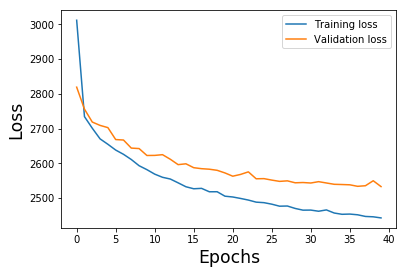

In [31]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_file,
                   normalized_data_file)